In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
import os.path
from sympy import Matrix

In [2]:
df_train = pd.read_csv('B:/Università/Machine Learning/Datasets/mnist_train.csv')
df_test = pd.read_csv('B:/Università/Machine Learning/Datasets/mnist_test.csv') 

In [3]:
X_train = np.array(df_train.iloc[:, 1:], dtype=np.float32)/255
Y_train = np.array(df_train.iloc[:, :1], dtype=np.int8)

X_test = np.array(df_test.iloc[:, 1:], dtype=np.float32)/255
Y_test = np.array(df_test.iloc[:, :1], dtype=np.int8)

In [4]:
def permutation(x, y, mode = 1, debug = False):
    if mode == 1:
        assert len(x) == len(y)
        i = np.random.permutation(len(y))
        if debug == True:
            print("order:", i)
            print("y not perm:", y)
            print("y perm:",np.array(y[i], dtype=np.int8))
            x_check = np.array(x[i], dtype=np.float32)
            index0 = i[0]
            if np.array_equal(x[index0], x_check[0]): 
                print("good")
            else:
                print("no good")
        if x.dtype == np.float32:
            return np.array(x[i], dtype=np.float32), np.array(y[i], dtype=np.int8), i
        else:
            return np.array(x[i], dtype=np.int32), np.array(y[i], dtype=np.int8), i
    if mode == 2:
        if debug == True:
            print("order:", y)
            if x.dtype == np.float32:
                x_check = np.array(x[y], dtype=np.float32)
                print("X set",x_check)
            else:
                x_check = np.array(x[y], dtype=np.int8)
                print("Y set",x_check)
            index0 = y[0]
            if np.array_equal(x[index0], x_check[0]): 
                print("good")
            else:
                print("no good")
        if x.dtype == np.float32:
            return np.array(x[y], dtype=np.float32)
        else:
            return np.array(x[y], dtype=np.int8)

In [5]:
X_train, Y_train, train_order = permutation(X_train, Y_train, 1)
#X_test, Y_test, test_order = permutation(X_test, Y_test, 1)

In [6]:
def poly_k_sym (x): # build symmetric matrix
    M = np.zeros((x.shape[0], x.shape[0]), dtype=np.float32) # matrix initialization
    start_time = time.time()
    for i in range(x.shape[0]): # it is built one column at a time
        for j in range(i+1): # simmetrically
            M[j,i] = (1 + np.dot(x[i], x[j])) # computation
            assert M[j,i] >= 0
        if ((i % (x.shape[0] / 4) == 0) and i != 0): # stamp time
            print("Matrix computation -> Row:", i, "in", time.time() - start_time, "seconds.")
    print("Matrix computed in:", time.time() - start_time, "seconds.", "\n") # end matrix stamp time
    return M

In [7]:
def comp_predictor(x, label, K, e, p, debug = False):
    yp = np.zeros((x.shape[0], 10), dtype=np.int8)
    S = np.zeros((x.shape[0], 10), dtype=np.int8) # number of mistakes
    S_epochs = []
    yp_epochs = []
    if debug == True:
        print("n° of epochs:", e)
    K = K**p
    for t in range(e):
        yp = np.zeros((x.shape[0], 10), dtype=np.int8)
        for i in range(x.shape[0]):
            matrow = np.append(K[:,i][:i], K[i,:][i:])
            for digit in range(10):
                y_hat = np.sum(matrow * S[:,digit] * label[:,digit]) # compute prediction for each obs
                yp[i,digit] = np.sign(y_hat) # only positive or negative matters
                if (label[i,digit] != yp[i,digit]):
                    S[i,digit] += 1
        if debug == True:
            print("t:", t, "Number of non-zero in S =", np.count_nonzero(S), "Number of elements taken:", np.sum(S))
        s = S.copy()
        S_epochs.append(s)
        if debug == True:
            print("t:", t, "lenght", len(S_epochs),"Number of non-zero in S =", np.count_nonzero(S_epochs[t]), "Number of elements taken:", np.sum(S_epochs[t]), type(S_epochs))
        yp_epochs.append(yp)
    if debug == True:
        if np.count_nonzero(S_epochs[0]) == np.count_nonzero(S_epochs[9]):
            print("wtf?!", np.count_nonzero(S_epochs[0]), np.count_nonzero(S_epochs[9]), len(S_epochs), type(S_epochs))
        else: 
            print("fine")

    return S_epochs, yp_epochs

In [8]:
def K_testing(x, y, epochs, poly, K = 0, debug = False): # uses symmetric matrix
    if type(K) is int: # compute the big matrix if not in argument
        #x, y, order = permutation(x, y, 1) # permutation of x and y simultaneusly
        print("Computing matrix...") 
        K = poly_k_sym(x)
        print("Matrix computed.")
        #reorder = True
    #else:
        #reorder = False
    S = np.zeros((x.shape[0], 10), dtype=np.int8) # number of mistakes
    num_ep = 0
    best_pred_error = 100

    label = np.zeros((y.shape[0], 10), dtype=np.int8)
    for d in range(10):
        label[:,d] = np.array([1 if v == d else -1 for v in y], dtype=np.int8)

    S_average_list = []
    best_epoch = 100
    # run for each digit
    for p in poly:  
        print("Polynomial:", p)
        S_average = np.zeros((x.shape[0], 10), dtype=np.int8)
            
        print("- - - Epoch:", epochs)
        start_time = time.time()
        S, predictor = comp_predictor(x, label, K, epochs[len(epochs) - 1], p, debug)
        print("Prediction computed in:", time.time() - start_time, "seconds.")
            
        #if debug == True:
        #    print("lenghts S and predictor:", len(S), len(predictor))
        for n in epochs: #adds only the averages of the epoch list
            S_average = np.zeros((x.shape[0], 10), dtype=np.int8)
            for g in range(n):
                S_average = S_average + S[g]
                #if debug == True: 
                #    print("g:", g)
            S_average = S_average / n  
            S_average_list.append(S_average)  
            
        if debug == True:
            if np.count_nonzero(S[0]) == np.count_nonzero(S[9]):
                print("wtf?!")

        for h in range(epochs[len(epochs) - 1]):   
            # 0-1 Loss
            pred = np.zeros(y.shape[0], dtype=np.int8)
            mistakes = np.zeros(y.shape[0], dtype=np.int8)
            predictor_e = predictor[h]
            if debug == True:
                print("epoch:", h, "shape:", predictor_e.shape, "N° of mistakes (initialization):", np.sum(mistakes))
                print("Number of non-zero in S =", np.count_nonzero(S[h]), "Number of elements taken:", np.sum(S[h]))            
            for m in range(x.shape[0]):
                pred[m] = np.argmax(predictor_e[m])
                if debug == True and (m % (x.shape[0] / 2) == 0):
                    print("obs:", m, "possible labels", predictor_e[m], "argmax:", pred[m], "label:", y[m])
                if pred[m] != y[m]:
                    mistakes[m] = 1
            pred_error = np.sum(mistakes) / x.shape[0] * 100
            if h in epochs and debug == True:
                print("Epoch:", h, "Zero One Loss:", pred_error, "%", "N° of mistakes:", np.sum(mistakes))
            if h in epochs and debug == False:
                print("Epoch:", h, "Zero One Loss:", pred_error, "%")
                num_ep += 1
            if pred_error < best_pred_error :#or (pred_error == best_pred_error and best_epoch > h):
                best_pred = S[h]
                best_pred_error = pred_error
                power = p
                best_epoch = h
        print("Best Training Error  -------  ","Epoch:", best_epoch, "Polynomial:", power, "Zero One Loss:", best_pred_error, "%")
        print("")

    return best_pred, power, S_average_list



In [9]:
def poly_k_pred (x, x_train): # not symmetric building, check for symmetry
    M = np.zeros((x_train.shape[0], x.shape[0]), dtype=np.float32)
    start_time = time.time()
    for i in range(x_train.shape[0]):
        for j in range(x.shape[0]):
            M[i,j] = (1 + np.dot(x_train[i], x[j]))
            assert M[i,j] >= 0   
        if ((i % (x_train.shape[0] / 4) == 0) and i != 0): 
            print("Matrix computation -> Row:", i, "in", time.time() - start_time, "seconds.")
    print("Matrix computed in:", time.time() - start_time, "seconds.", "\n")
    return M

In [10]:
def Kpredict(x, y_train, poly, S, GM, y_test, debug = False):

    assert x.shape[0] == y_test.shape[0]
    
    # definition of variables
    y_p = np.zeros((x.shape[0], 10), dtype=np.int8)
    label = np.zeros((y_train.shape[0], 10), dtype=np.int8)
    for digit in range(10):
        label[:,digit] = np.array([1 if v == digit else -1 for v in y_train], dtype=np.int8)    

    n_p = 0
    print("Starting predictions computation.")
    start_time = time.time()

    if type(poly) is list:
        index = 0
        start_time_list = start_time
        m_preds = []
        for p in poly:
            K = GM**p
            #print(index)
            for n in range(len(S)//len(poly)):
              pred = np.zeros(x.shape[0], dtype=np.int8)
              S_av = S[index]
              if debug == True:
                  print("Check lenght:", n, p, len(S), len(poly),(len(S)//len(poly)))
              for i in range(x.shape[0]): # for each observation
                  for digit in range(10): # check if could be each digit
                      y_hat = np.sum(K[:,i] * S_av[:,digit] * label[:,digit])  # prediction
                      y_p[i,digit] = np.sign(y_hat)

                      #if debug == True and (i % (x.shape[0] / 4) == 0):
                          #print("obs:", i, "digit-try:", digit, "result:", y_hat, "label:", y_test[i])
                      #if debug == True and i == x.shape[0] - 1:
                          #print("digit:", digit, "positive label array:", np.sum(label[:,digit] > 0))
                        
                  pred[i] = np.argmax(y_p[i])
              m_preds.append(pred)
              index = index + 1

            print("Prediction computation -> Polynomial:", p, "in", time.time() - start_time_list, "seconds.")
            start_time_list = time.time()
              

            # zero one loss
            for e in range(len(S)//len(poly)):
                mistakes = np.zeros(x.shape[0], dtype=np.int8)
                prediction = m_preds[e + (len(S)//len(poly))*n_p]
                if debug == True:
                    print("indexes", n_p, e + (len(S)//len(poly))*n_p)
                for m in range(x.shape[0]):
                    #if debug == True and (m % (x.shape[0] / 4) == 0):
                        #print("obs", m, "possible labels", y_p[m], "argmax:", prediction[m], "label:", y_test[m])
                    if prediction[m] != y_test[m]:
                        mistakes[m] = 1
                error = np.sum(mistakes) / x.shape[0] * 100
                print("Average for polynomial:", poly[n_p], e, " ---------- ","Zero One Loss:", error, "%\n")
            n_p += 1
        
        print("Total time:", time.time() - start_time, "seconds.\n")

        return m_preds

    else:
        K = GM**poly
        pred = np.zeros(x.shape[0], dtype=np.int8)
        for i in range(x.shape[0]): # for each observation
            for digit in range(10): # check if could be each digit
                y_hat = np.sum(K[:,i] * S[:,digit] * label[:,digit])  # prediction
                y_p[i,digit] = np.sign(y_hat)

                if debug == True and (i % (x.shape[0] / 4) == 0):
                    print("obs:", i, "digit-try:", digit, "result:", y_hat, "label:", y_test[i])
                if debug == True and i == x.shape[0] - 1:
                    print("digit:", digit, "positive label array:", np.sum(label[:,digit] > 0))
                if ((i % (x.shape[0] / 4) == 0) and i != 0 and digit == 9): # time stamp
                    print("Prediction computation -> Observation:", i, "in", time.time() - start_time, "seconds.")
                      
            pred[i] = np.argmax(y_p[i])
    
        # zero one loss
        print("Computing zero-one loss.")
        mistakes = np.zeros(x.shape[0], dtype=np.int8)
        for m in range(x.shape[0]):
            if debug == True and (m % (x.shape[0] / 4) == 0):
                print("obs", m, "possible labels", y_p[m], "argmax:", pred[m], "label:", y_test[m])
            if pred[m] != y_test[m]:
                mistakes[m] = 1
        error = np.sum(mistakes) / x.shape[0] * 100
        print("Zero One Loss:", error, "%")
        print("Total time:", time.time() - start_time, "seconds.\n")

        return pred

In [11]:
epochs =  [5,10,15,20,25]
polynomials = [2,4,6]

In [12]:
Matrix = poly_k_sym(X_train)

Matrix computation -> Row: 15000 in 726.2608923912048 seconds.
Matrix computation -> Row: 30000 in 2867.5619542598724 seconds.
Matrix computation -> Row: 45000 in 6408.52672457695 seconds.
Matrix computed in: 11462.116043567657 seconds. 



In [13]:
best_train, best_poly, average = K_testing(X_train, Y_train, epochs, polynomials, Matrix, debug = False)

Polynomial: 2
- - - Epoch: [5, 10, 15, 20, 25]
Prediction computed in: 2085.816778898239 seconds.
Epoch: 5 Zero One Loss: 2.328333333333333 %
Epoch: 10 Zero One Loss: 1.1516666666666666 %
Epoch: 15 Zero One Loss: 0.61 %
Epoch: 20 Zero One Loss: 0.39166666666666666 %
Best Training Error  -------   Epoch: 23 Polynomial: 2 Zero One Loss: 0.305 %

Polynomial: 4
- - - Epoch: [5, 10, 15, 20, 25]
Prediction computed in: 2135.3176884651184 seconds.
Epoch: 5 Zero One Loss: 0.40499999999999997 %
Epoch: 10 Zero One Loss: 0.075 %
Epoch: 15 Zero One Loss: 0.0 %
Epoch: 20 Zero One Loss: 0.0 %
Best Training Error  -------   Epoch: 15 Polynomial: 4 Zero One Loss: 0.0 %

Polynomial: 6
- - - Epoch: [5, 10, 15, 20, 25]
Prediction computed in: 2275.1081490516663 seconds.
Epoch: 5 Zero One Loss: 0.13666666666666666 %
Epoch: 10 Zero One Loss: 0.006666666666666667 %
Epoch: 15 Zero One Loss: 0.0 %
Epoch: 20 Zero One Loss: 0.0 %
Best Training Error  -------   Epoch: 15 Polynomial: 4 Zero One Loss: 0.0 %



In [14]:
predMatrix = poly_k_pred(X_test,X_train)

Matrix computation -> Row: 15000 in 1053.9401886463165 seconds.
Matrix computation -> Row: 30000 in 2121.2537088394165 seconds.
Matrix computation -> Row: 45000 in 3180.3357651233673 seconds.
Matrix computed in: 4244.760777235031 seconds. 



In [15]:
pred_mintrain = Kpredict(X_test,Y_train,best_poly,best_train,predMatrix,Y_test)

Starting predictions computation.
Prediction computation -> Observation: 2500 in 16.236318349838257 seconds.
Prediction computation -> Observation: 5000 in 27.167823553085327 seconds.
Prediction computation -> Observation: 7500 in 38.137338638305664 seconds.
Computing zero-one loss.
Zero One Loss: 2.93 %
Total time: 49.13285827636719 seconds.



In [16]:
pred_average = Kpredict(X_test,Y_train,polynomials,average,predMatrix,Y_test)

Starting predictions computation.
Prediction computation -> Polynomial: 2 in 456.3761270046234 seconds.
Average for polynomial: 2 0  ----------  Zero One Loss: 4.06 %

Average for polynomial: 2 1  ----------  Zero One Loss: 3.7900000000000005 %

Average for polynomial: 2 2  ----------  Zero One Loss: 3.6799999999999997 %

Average for polynomial: 2 3  ----------  Zero One Loss: 83.1 %

Average for polynomial: 2 4  ----------  Zero One Loss: 89.95 %

Prediction computation -> Polynomial: 4 in 448.64444303512573 seconds.
Average for polynomial: 4 0  ----------  Zero One Loss: 3.02 %

Average for polynomial: 4 1  ----------  Zero One Loss: 2.87 %

Average for polynomial: 4 2  ----------  Zero One Loss: 2.88 %

Average for polynomial: 4 3  ----------  Zero One Loss: 3.4000000000000004 %

Average for polynomial: 4 4  ----------  Zero One Loss: 10.780000000000001 %

Prediction computation -> Polynomial: 6 in 435.8054361343384 seconds.
Average for polynomial: 6 0  ----------  Zero One Loss: 3.

In [46]:
errors_min = []
zeroerrors = 0
for i in range(len(Y_test)):
    if Y_test[i] != pred_mintrain[i]:
        errors_min.append(i)
        print("Error N°:", i, "Prediction:", pred_mintrain[i], "Actual Value:", Y_test[i])
        if pred_mintrain[i] == 0:
            zeroerrors += 1

print("N° of mistakes:", len(errors_min))
print("N° of wrong zero predictions:", zeroerrors)

Error N°: 8 Prediction: 0 Actual Value: [5]
Error N°: 33 Prediction: 0 Actual Value: [4]
Error N°: 104 Prediction: 5 Actual Value: [9]
Error N°: 115 Prediction: 0 Actual Value: [4]
Error N°: 124 Prediction: 4 Actual Value: [7]
Error N°: 241 Prediction: 0 Actual Value: [9]
Error N°: 247 Prediction: 2 Actual Value: [4]
Error N°: 320 Prediction: 8 Actual Value: [9]
Error N°: 340 Prediction: 3 Actual Value: [5]
Error N°: 445 Prediction: 0 Actual Value: [6]
Error N°: 447 Prediction: 0 Actual Value: [4]
Error N°: 448 Prediction: 0 Actual Value: [9]
Error N°: 495 Prediction: 0 Actual Value: [8]
Error N°: 507 Prediction: 0 Actual Value: [3]
Error N°: 551 Prediction: 0 Actual Value: [7]
Error N°: 582 Prediction: 2 Actual Value: [8]
Error N°: 583 Prediction: 0 Actual Value: [2]
Error N°: 659 Prediction: 0 Actual Value: [2]
Error N°: 684 Prediction: 0 Actual Value: [7]
Error N°: 720 Prediction: 8 Actual Value: [5]
Error N°: 839 Prediction: 3 Actual Value: [8]
Error N°: 844 Prediction: 7 Actual Va

In [57]:
errors = []
zeroerrors = 0
pred_check = pred_average[6]
for i in range(len(Y_test)):
    if Y_test[i] != pred_check[i]:
        errors.append(i)
        print("Error N°:", i, "Prediction:", pred_check[i], "Actual Value:", Y_test[i])
        if pred_check[i] == 0:
            zeroerrors += 1

print("N° of mistakes:", len(errors))
print("N° of wrong zero predictions:", zeroerrors)

Error N°: 33 Prediction: 0 Actual Value: [4]
Error N°: 115 Prediction: 0 Actual Value: [4]
Error N°: 124 Prediction: 4 Actual Value: [7]
Error N°: 217 Prediction: 5 Actual Value: [6]
Error N°: 241 Prediction: 0 Actual Value: [9]
Error N°: 247 Prediction: 2 Actual Value: [4]
Error N°: 320 Prediction: 8 Actual Value: [9]
Error N°: 340 Prediction: 3 Actual Value: [5]
Error N°: 359 Prediction: 0 Actual Value: [9]
Error N°: 417 Prediction: 0 Actual Value: [9]
Error N°: 445 Prediction: 0 Actual Value: [6]
Error N°: 447 Prediction: 0 Actual Value: [4]
Error N°: 448 Prediction: 0 Actual Value: [9]
Error N°: 449 Prediction: 5 Actual Value: [3]
Error N°: 495 Prediction: 0 Actual Value: [8]
Error N°: 551 Prediction: 0 Actual Value: [7]
Error N°: 582 Prediction: 2 Actual Value: [8]
Error N°: 583 Prediction: 0 Actual Value: [2]
Error N°: 629 Prediction: 0 Actual Value: [2]
Error N°: 659 Prediction: 0 Actual Value: [2]
Error N°: 684 Prediction: 0 Actual Value: [7]
Error N°: 720 Prediction: 0 Actual 

In [48]:
from collections import Counter

def count_intersections(lst1, lst2):
    c1 = Counter(lst1)
    c2 = Counter(lst2)
    return { k: min(c1[k], c2[k]) for k in c1.keys() & c2.keys() }

len(count_intersections(errors, errors_min))

248

In [19]:
np.savetxt("pred_mintrain.txt", pred_mintrain)
np.savetxt("pred_average.txt", pred_average)

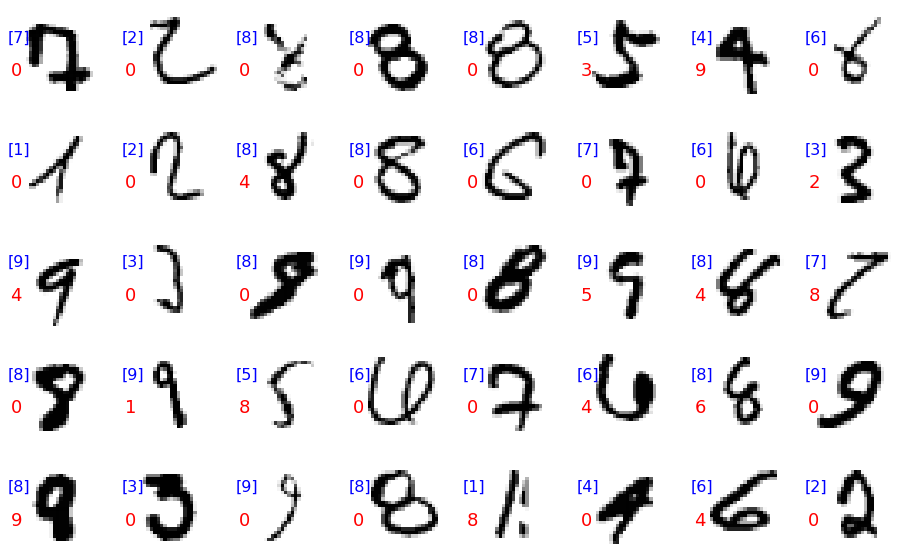

In [62]:
sel = np.random.choice(errors, 40, replace=False)

image_sel = X_test[sel,:]
label_sel = Y_test[sel]
pred_check = pred_average[6][sel]

plt.close()
plt.rcParams["figure.figsize"] = [16,10]

for i in range(40):
    img = image_sel[i].reshape(28,28)
    lab = label_sel[i]
    predicted = pred_check[i]
    
    plt.subplot(5,8,i+1)
    plt.imshow(img, cmap='binary')
    plt.text(-1, 10, s = str(lab), fontsize=16, color='b')
    plt.text(0, 20, s = str(predicted), fontsize=18, color='r')
    plt.axis('off')

plt.show()
#print(sel)